# **Business and Data Understanding**

## Business Understanding

SyriaTel wants to reduce customer churn (leave) by identifying which customers are likely to leave. Churn is costly, so catching high-risk customers early allows targeted retention efforts, like special offers or support. The goal is to build a model that predicts churn accurately, prioritizing recall to catch as many potential churners as possible while keeping precision reasonable.

## Objectives

- Predict which SyriaTel customers are likely to churn.  
- Identify the key factors driving churn.  
- Build a model that prioritizes recall to catch most potential churners.  
- Provide actionable insights for targeted retention strategies.  
- Ensure the workflow is reproducible and easy to update with new data.


# **Loading Data and Initial Data Inspection**

In [33]:
# Import necessary libraries (we import only the parts we need to save on memory)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.inspection import partial_dependence
import warnings
warnings.filterwarnings('ignore')


# Set the style for seaborn
sns.set_style("whitegrid")

# Load the dataset
file_path = 'SyriaTel_Churn.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [34]:
# Check the structure of the dataset
data.info()

# Check for missing values
data.isnull().sum()

# Check the class distribution of the 'churn' variable
data['churn'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

churn
False    2850
True      483
Name: count, dtype: int64

- **No Missing Data**: All 3333 rows have values for every column, so we don’t need to handle missing data.  

- **Class Imbalance**: The `churn` column is imbalanced, with 2850 customers not churned (`False`) and 483 churned (`True`).  

- **Class Weights**: To address the imbalance, we give the churn class more weight during model training. This helps the model pay more attention to churners and improves recall without changing the data itself.  

These points are important for understanding the dataset. With no missing values, preprocessing is simpler. The class imbalance means we need to handle it carefully, and using class weights is one effective approach to ensure the model identifies potential churners.


# **Exploratory Data Analysis (EDA)**

We used visualizations to explore the dataset and understand patterns in customer behavior. The analysis covers three levels:  

1. **Univariate Analysis**: Examine individual features to understand their distributions, spot outliers, and get a sense of typical values.  
2. **Bivariate Analysis**: Compare features against the target (`churn`) to see how each variable relates to churn risk.  
3. **Multivariate Analysis**: Look at combinations of features to uncover interactions and complex patterns that may indicate higher churn likelihood.  

This structured approach helps us identify which features are most relevant for modeling and informs statistical and machine learning analyses.


## **Univarite Analysis**

### I. Histogram showing distribution of account length

### Why this plot?

We want to see how long customers have been with SyriaTel. Understanding the distribution of account lengths can help us spot patterns, outliers, or trends that may relate to churn.

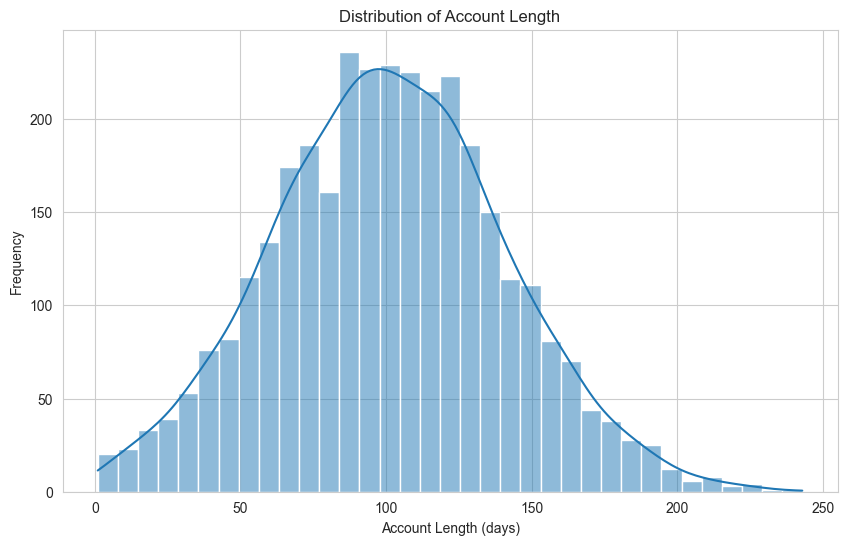

In [35]:
# Histogram of account length
plt.figure(figsize=(10, 6))
sns.histplot(data['account length'], kde=True)
plt.title('Distribution of Account Length')
plt.xlabel('Account Length (days)')
plt.ylabel('Frequency')
plt.show()

- *Shape*: The distribution is roughly normal with a bell-shaped curve, indicating that most customers have been with the company for a similar duration.
- *Peak*: The highest frequency of accounts falls around 100 days, suggesting this is the most common account length.
- *Spread*: The spread of account lengths is fairly symmetric around the peak, with frequencies gradually decreasing as account lengths move away from the peak.
- *Outliers*: There are a few customers with account lengths significantly above 200 days, which could be considered outliers.

### II. Histogram showing distribution of Customer Service Calls

### Why This Plot?

We want to understand how often customers contact customer service. High call frequency may indicate dissatisfaction, which could be linked to higher churn risk.

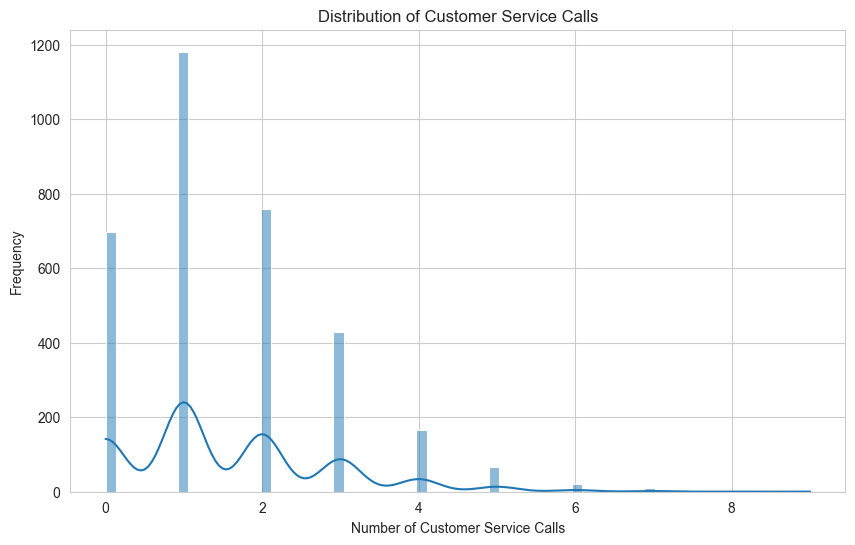

In [36]:
# Histogram of customer service calls
plt.figure(figsize=(10, 6))
sns.histplot(data['customer service calls'], kde=True)
plt.title('Distribution of Customer Service Calls')
plt.xlabel('Number of Customer Service Calls')
plt.ylabel('Frequency')
plt.show()

- *Peaks*: There are prominent peaks at 0, 1, and 2 calls, indicating these are the most common numbers of calls made to customer service.
- *Skewness*: The distribution is skewed to the left, with a long tail extending to the right. This suggests that while most customers make few calls, there are some who make a significantly higher number of calls.
- *Frequency*: The highest frequency is at 1 call, with over 1200 customers having made just one call to customer service.
- *Outliers*: There are a few customers with a high number of calls (more than 6), which could be outliers or indicate a potential issue with the service or a particular group of customers.

This distribution suggests that a small number of calls to customer service is typical, but there is a significant number of customers who have had no contact with customer service, which might be a positive sign. The long tail indicates that a small group of customers are responsible for a large number of calls, which could be a focus for service improvement efforts.

### III. Bar Graph for International Plan

### Why This Plot?
We want to see how many customers have an international plan. This helps us understand if having an international plan affects churn.


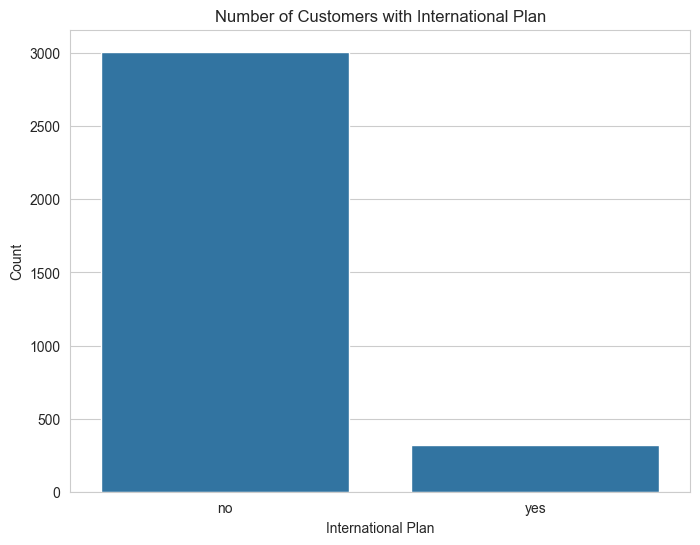

In [37]:
# Graphing Count plot for international plan
plt.figure(figsize=(8, 6))
sns.countplot(x='international plan', data=data)
plt.title('Number of Customers with International Plan')
plt.xlabel('International Plan')
plt.ylabel('Count')
plt.show()

- *Comparison*: The chart shows that a larger number of customers do not have an international plan compared to those who do.
- *Counts*: Approximately 3000 customers do not have an international plan, while around 300 customers have one.
- *Implication*: The majority of customers are domestic users, which could imply that the company's market is primarily local or that international plans are not widely popular or necessary for most customers.
- *Business Insight*: Understanding this distribution is crucial for the company to decide whether to focus on retaining the domestic customer base or to invest in strategies to promote international plans.

### IV. Bar Graph showing count for voice mail plan

### Why This Plot?
We want to see how many customers have a voice mail plan. This helps us understand if having a voice mail plan is related to churn.


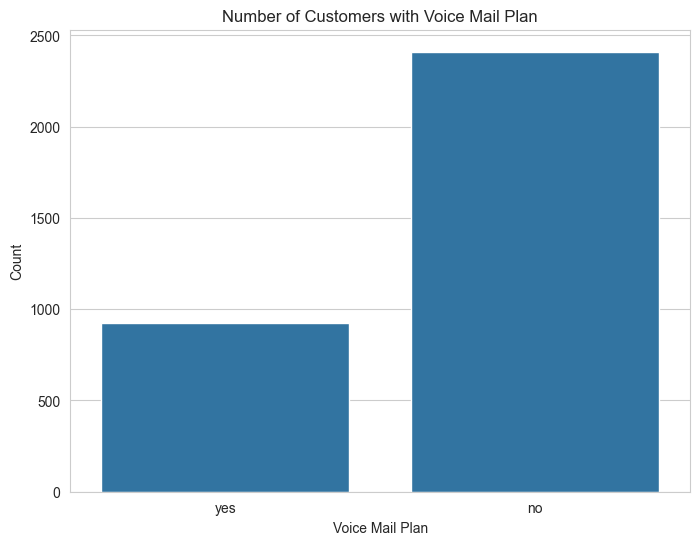

In [38]:
# Count plot for voice mail plan
plt.figure(figsize=(8, 6))
sns.countplot(x='voice mail plan', data=data)
plt.title('Number of Customers with Voice Mail Plan')
plt.xlabel('Voice Mail Plan')
plt.ylabel('Count')
plt.show()

- *Comparison*: The chart shows that a larger number of customers do not have a voice mail plan compared to those who do.
- *Counts*: Around 2400 customers have a voice mail plan, while approximately 2000 customers do not.
- *Implication*: The majority of customers are without a voice mail plan, which might suggest that this feature is not widely popular or necessary among the customer base.
- *Business Insight*: The company might consider whether to promote the voice mail plan more actively or to understand why it is not widely adopted by customers.

## **Bivariate Analysis**

### I. Violin Plot of total day minutes vs. churn

### Why this plot?
A violin plot combines box plots with kernel density plots to show the distribution's shape and density at different values. It's less sensitive to outliers than box plots, hence we will use it for this plot

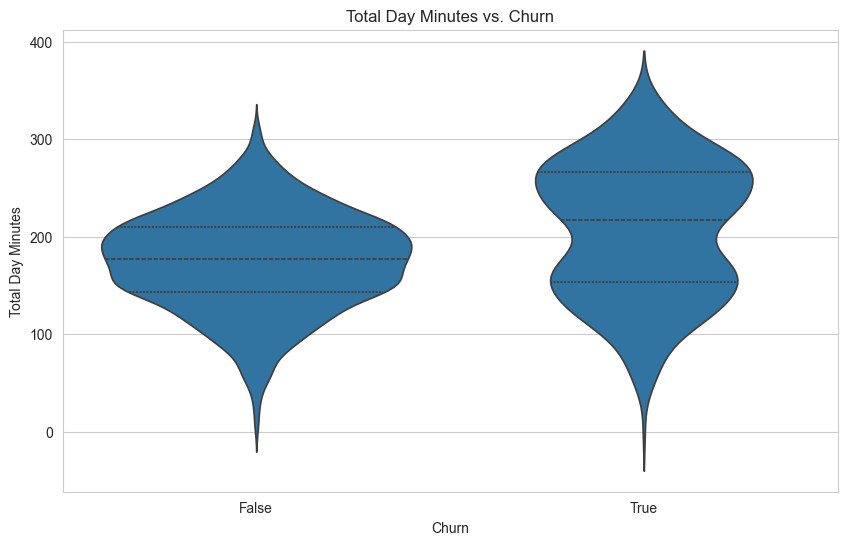

In [39]:
# Plotting the Violin plot of total day minutes vs. churn
plt.figure(figsize=(10, 6))
sns.violinplot(x='churn', y='total day minutes', data=data, inner='quartile')
plt.title('Total Day Minutes vs. Churn')
plt.xlabel('Churn')
plt.ylabel('Total Day Minutes')
plt.show()

- *Distribution Shape*: The plot for both groups is symmetric, suggesting a normal distribution of `total day minutes` for both churned and non-churned customers.
- *Central Tendency*: The median (dashed line inside the violins) appears similar for both groups, indicating no significant difference in the central tendency of `total day minutes`.
- *Spread*: The spread of `total day minutes` is comparable for both groups, with a slight hint that non-churned customers might have a slightly wider spread.
- *Overlap*: There's a considerable overlap between the two distributions, implying that `total day minutes` alone does not strongly differentiate between churned and non-churned customers.
- *Outliers*: Both groups have a similar presence of outliers, with a few customers having extremely high `total day minutes`.

This plot suggests that while `total day minutes` might be a factor in churn, it does not show a clear distinction between churned and non-churned customers based on this feature alone. Further analysis with additional features may be necessary to better understand churn behavior.

### II. Scatter Plot for customer service calls and churn

### Why this plot?
A scatter plot with a regression line can show the trend between two variables. The logistic regression line helps in understanding the relationship for binary outcomes by giving us a rough idea for probabilities.

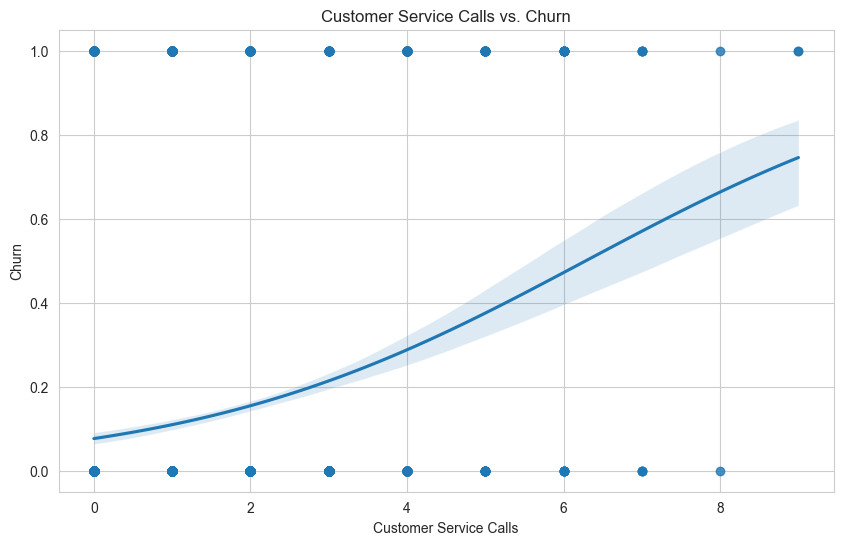

In [40]:
# Scatter plot with regression line of customer service calls vs. churn
plt.figure(figsize=(10, 6))
sns.regplot(x='customer service calls', y='churn', data=data, logistic=True)
plt.title('Customer Service Calls vs. Churn')
plt.xlabel('Customer Service Calls')
plt.ylabel('Churn')
plt.show()

This scatter plot with a regression line visualizes the relationship between the number of customer service calls and the probability of churn. Here's the interpretation:

- The upward trend in the regression line shows as the number of customer service calls increases, the likelihood of churn also increases.
- The positive slope of the line indicates a positive correlation between customer service calls and churn.
- The shaded area around the regression line represents the confidence interval, showing the range within which the true regression line is likely to fall.
- There are several points that lie away from the regression line, particularly at higher numbers of customer service calls, indicating potential outliers or customers with unique characteristics.

This plot suggests that frequent calls to customer service are associated with a higher risk of churn, which could imply dissatisfaction or other issues that lead to churn. This insight could be valuable for targeted customer retention strategies.

### IV. Bar Plot showing churn among customers with/without customer service plan

### Why This Plot?
This bar plot will show the churn rate among customers with and without an international plan. It helps in understanding if having an international plan influences churn.

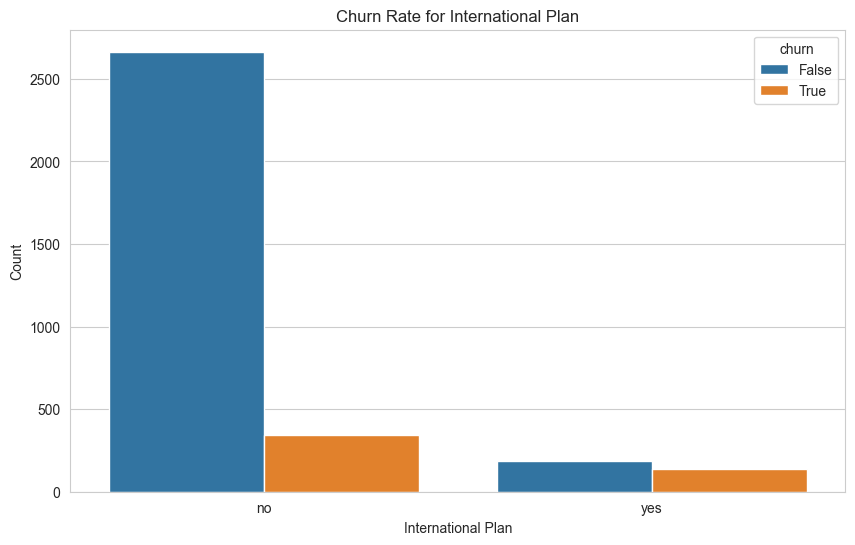

In [41]:
# Bar plot showing churn rate for customers with and without an international plan
plt.figure(figsize=(10, 6))
sns.countplot(x='international plan', hue='churn', data=data)
plt.title('Churn Rate for International Plan')
plt.xlabel('International Plan')
plt.ylabel('Count')
plt.show()

In [42]:
# Calculate churn percentages for each international plan category
churn_percentages_intl = data.groupby('international plan')['churn'].value_counts(normalize=True).mul(100).unstack()
churn_percentages_intl

churn,False,True
international plan,,
no,88.504983,11.495017
yes,57.585139,42.414861


This bar chart presents the churn rate for customers with and without an international plan. Here's a brief interpretation:

- *Churn Rate Comparison*: The chart compares the count of churned customers (True) versus non-churned customers (False) between those with and without an international plan.
- *Observation*: A significantly higher percentage of customers with an international plan have churned compared to those without an international plan.
- *Insight*: Not having an international plan seems to be associated with a lower churn rate, as the percentage of churned customers with an international plan is much higher.

This visualization suggests that customers with an international plan are more likely to churn, which could be valuable information for customer retention strategies focusing on plan offerings.

### IV. Bar Plot showing churn among customers with/without voice mail plan

### Why this plot?
This visualization will compare the churn rates between customers who have a voice mail plan and those who do not. It provides insights into whether the voice mail plan feature affects customer retention.

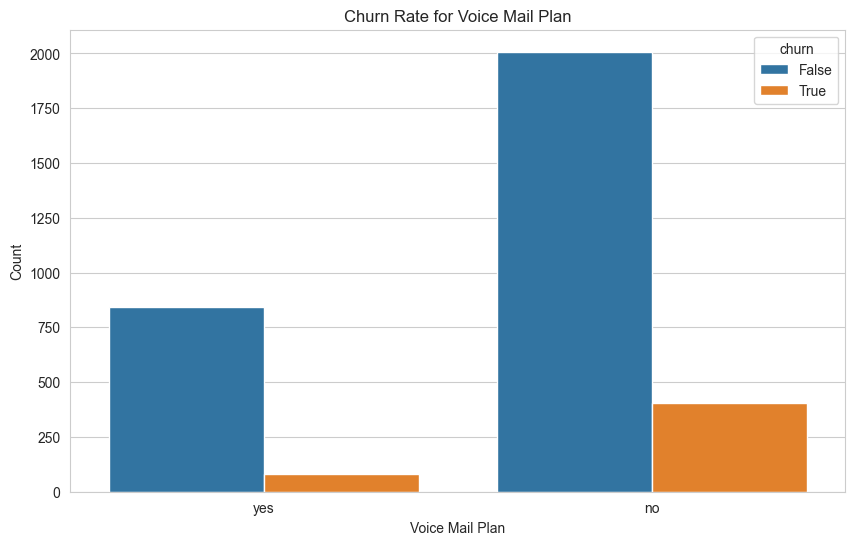

In [43]:
# Bar plot showing churn rate for customers with and without a voice mail plan
plt.figure(figsize=(10, 6))
sns.countplot(x='voice mail plan', hue='churn', data=data)
plt.title('Churn Rate for Voice Mail Plan')
plt.xlabel('Voice Mail Plan')
plt.ylabel('Count')
plt.show()

In [44]:
# Calculate churn percentages for each voice mail plan category
churn_percentages = data.groupby('voice mail plan')['churn'].value_counts(normalize=True).mul(100).unstack()
churn_percentages

churn,False,True
voice mail plan,,
no,83.284944,16.715056
yes,91.323210,8.676790


- *Comparison*: The chart shows that customers without a voice mail plan have a higher churn rate compared to those with a voice mail plan.
- *Non-churned customers*: 83% non-churned customers without a voice mail plan and 91% non-churned customers with a voice mail plan.
- *Churned Customers*: There are about 9% churned customers with a voice mail plan and roughly 17% churned customers without a voice mail plan.
- *Insight*: The presence of a voice mail plan appears to be associated with a lower churn rate, suggesting that this feature may contribute to customer retention.

## **Multivariate Analysis**

### I. Scatter plot with hue coding showing total day minutes against total day charge

### Why this plot?
This scatter plot with hue coding for churn will help us visualize if there's a pattern in how usage (minutes) relates to cost that affects churn.

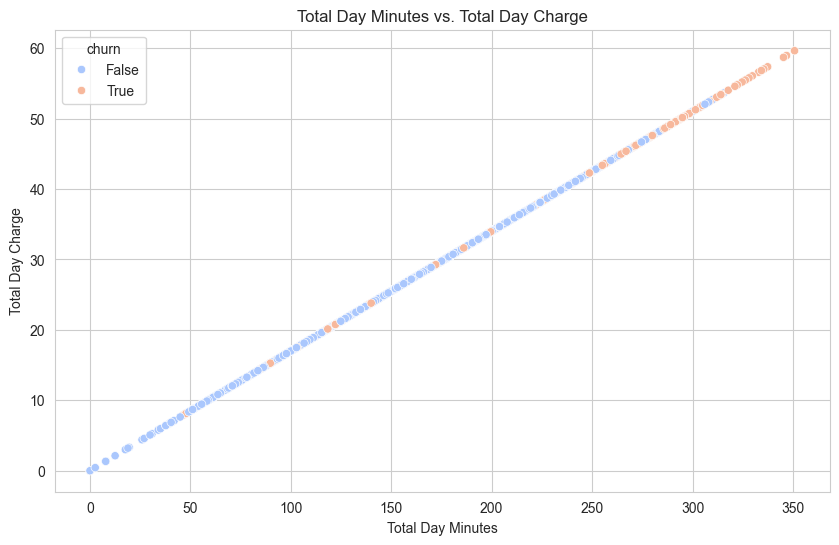

In [45]:
# Scatter plot of total day minutes vs. total day charge, colored by churn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total day minutes', y='total day charge', hue='churn', data=data, palette='coolwarm')
plt.title('Total Day Minutes vs. Total Day Charge')
plt.xlabel('Total Day Minutes')
plt.ylabel('Total Day Charge')
plt.show()

While the linear relationship between minutes and charge is consistent, the density of "True" (churned) customers appears to increase at higher usage levels.

This suggests that while the **`price per minute` is not the reason for churn**, the **`total cost`** of the service may be. Customers with very high day usage receive a high total charge, and this high overall bill could be the primary driver for them to churn. This is a common pattern in business, where the value proposition breaks down at the highest usage tiers, even if the per-unit price remains constant.

### II. Grouped Bar Chart showing churn rate variation by state and presence of an international plan

### Why this plot?
This grouped bar chart will show how the churn rate varies by state and the presence of an international plan, providing insights into geographical and plan-related churn factors.

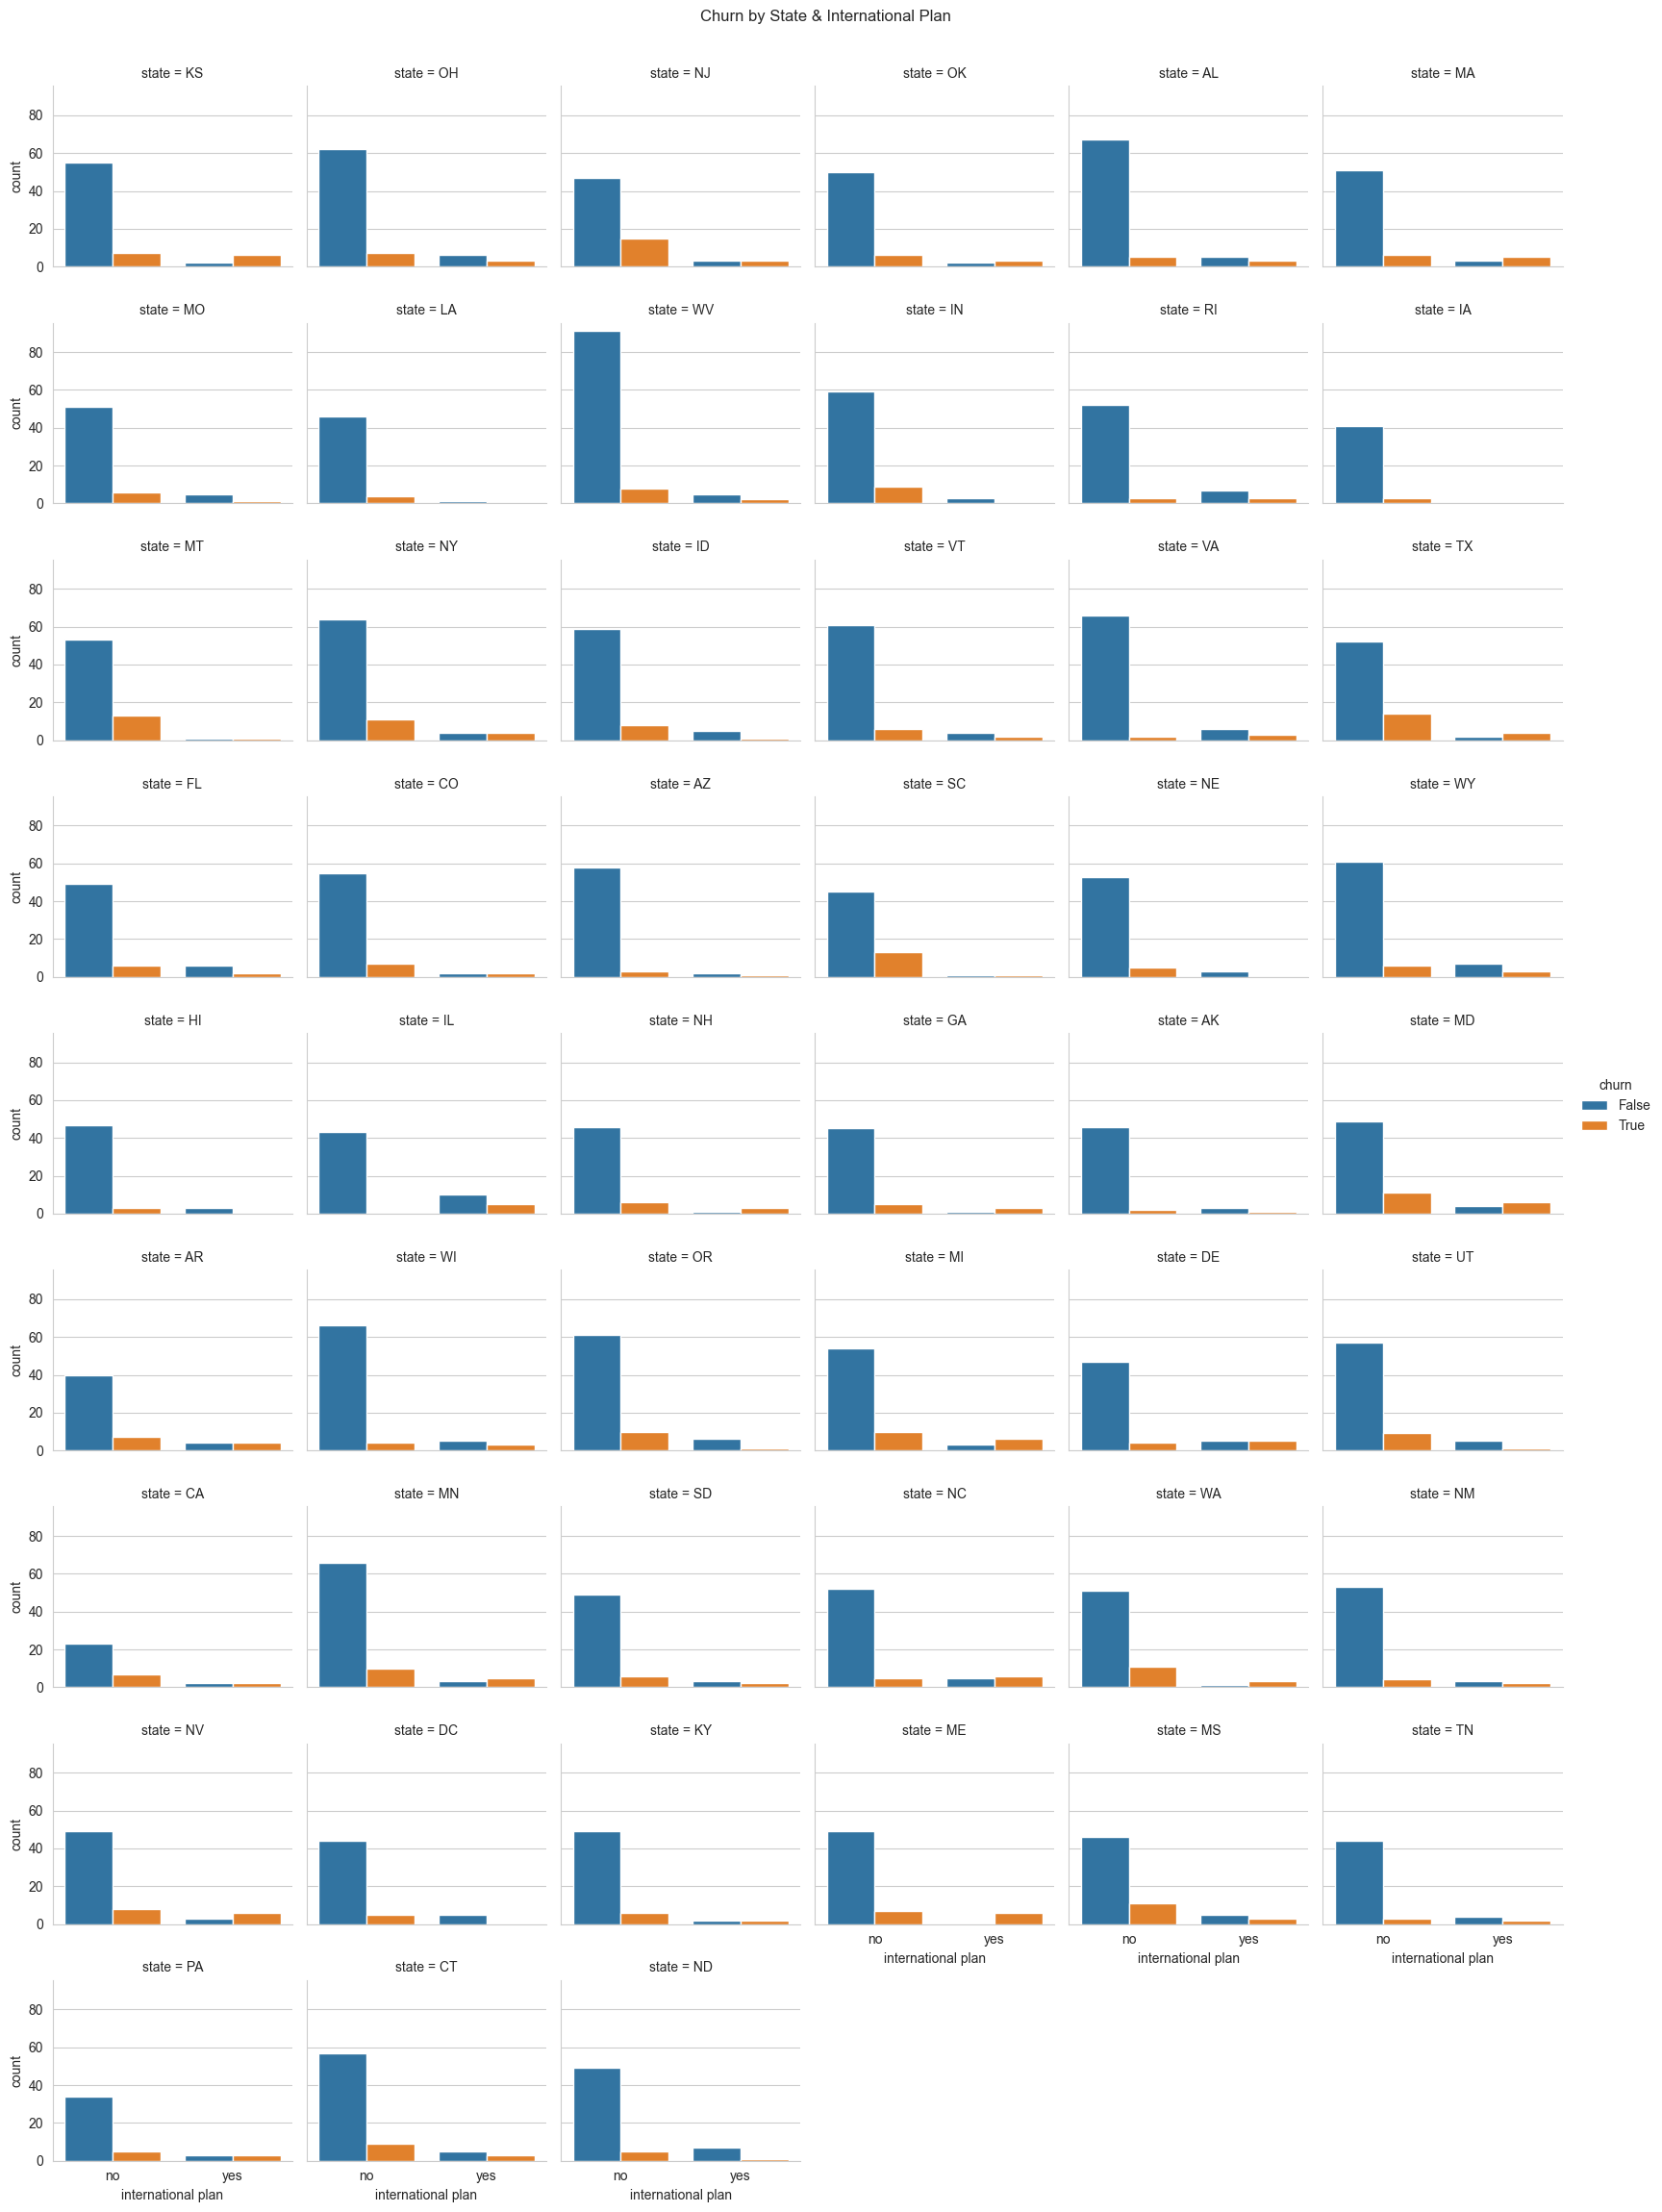

In [46]:
g = sns.catplot(
    kind='count',
    data=data,
    x='international plan',
    hue='churn',
    col='state',
    col_wrap=6,
    height=2.5,
    aspect=1.1
)

g.fig.suptitle('Churn by State & International Plan', y=1.02)
plt.show()


- *State Variation*: Customer churn rates vary significantly by state. States like KS, OH, and NJ appear to have some of the highest churn, while states like CA, MN, and WA seem to be among the lowest.

- There is a very strong and clear correlation between the International Plan and churn. Customers who have the International Plan are significantly more likely to churn than those who do notas seen in DC, PA, ND, UT, WA and almost every other state

In short, the company's churn problem is not uniform; it is concentrated in specific states and is heavily driven by customers who subscribe to the International Plan.

### III. Correlation Heatmap for all numeric variables

### Why this plot?
The correlation heatmap will help us identify multicollinearity and the strength of relationships between all numerical variables, aiding in feature selection and dropping columns with perfect correlation to prevent data leakage.

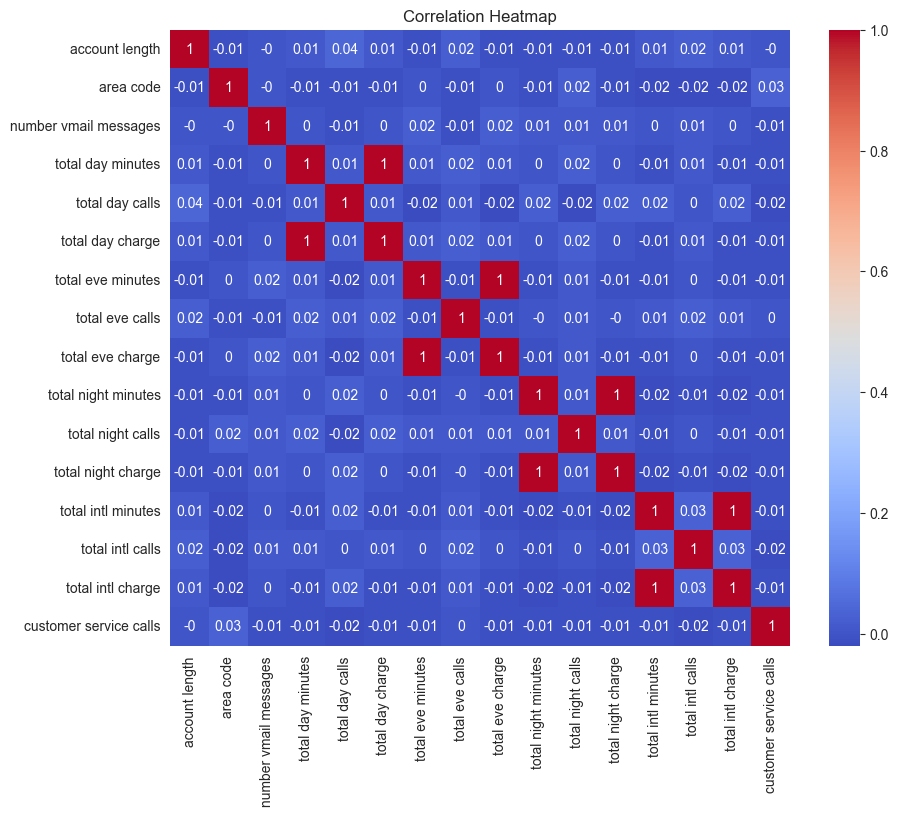

In [47]:
numeric_data = data.select_dtypes(include='number')

plt.figure(figsize=(10, 8))
sns.heatmap(
    numeric_data.corr().round(2),  # round to 2 decimal places
    annot=True,
    cmap='coolwarm'
)
plt.title('Correlation Heatmap')
plt.show()

The heatmap confirms expected relationships (like minutes and their corresponding charges) but suggests that most of the other features in the dataset are largely independent of each other in a linear sense.

### IV. Pair Plot showing usage pattern across different times of the day

### Why this plot?
This pair plot will explore how usage patterns across different times of the day (day, evening, night) relate to each other and to churn, providing a deeper understanding of usage behaviors.

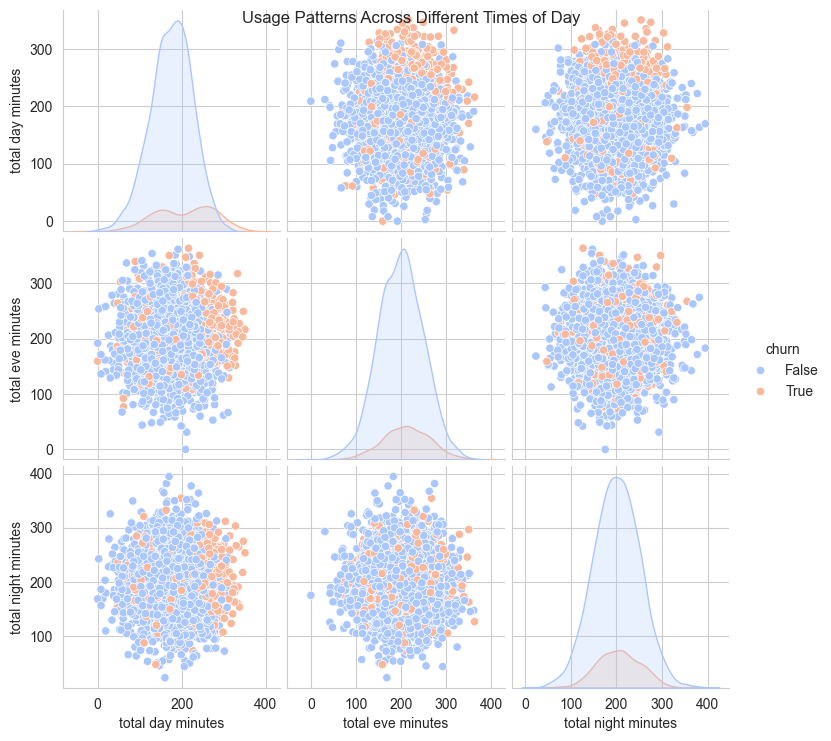

In [48]:
sns.pairplot(
    data[['total day minutes',
          'total eve minutes',
          'total night minutes',
          'churn']],       # include churn for hue
    hue='churn',
    palette='coolwarm'
)

plt.suptitle('Usage Patterns Across Different Times of Day')
plt.show()

*Churn Risk Indicator*: High daytime usage (300+ minutes) shows clear clustering of churned users, suggesting excessive early engagement may predict user burnout from high pricing.

*Optimal Retention Pattern*: Moderate, balanced usage across day and evening periods correlates with better user retention.

*Day Usage*: Generally lower and more variable, with heavy day users showing increased churn tendency.

*Retention Sweet Spot*: Users with 100-300 minutes of day/evening usage show highest retention rates, avoiding both under-engagement (not needing the service) and over-engagement (higher price) extremes.

## **Inferential Analysis**

Let's start by computing some basic statistics to know which tests to use.

In [49]:
#separate 'total day minutes' for churned and stayed customers
churned_min = data.loc[data['churn'], 'total day minutes']   # Only rows where churn == True
stayed_min  = data.loc[~data['churn'], 'total day minutes']  # Only rows where churn == False

churned_mean = churned_min.mean()
stayed_mean  = stayed_min.mean()

churned_median = churned_min.median()
stayed_median  = stayed_min.median()

# Print the results
print(f"Churned mean: {churned_mean:.2f}")
print(f"Stayed mean: {stayed_mean:.2f}")
print(f"Churned median: {churned_median:.2f}")
print(f"Stayed median: {stayed_median:.2f}")

# Print the differences to see the gap between churned and stayed customers
print(f"Mean difference: {churned_mean - stayed_mean:.2f}")
print(f"Median difference: {churned_median - stayed_median:.2f}")


Churned mean: 206.91
Stayed mean: 175.18
Churned median: 217.60
Stayed median: 177.20
Mean difference: 31.74
Median difference: 40.40


### I. Levene’s test on day-minutes variance

Many statistical tests (for example, the classic two-sample t-test) assume equal variances. If that assumption is false, results from those tests can be misleading.  

**Levene’s test** checks this assumption:  

- *H0 (Null Hypothesis)*: The variances of the groups are equal.  
- *H1 (Alternative Hypothesis)*: The variances of the groups are not equal.  

Levene’s test works well even when the data are not normally distributed.

In [50]:
levene_stat, p_levene = levene(churned_min, stayed_min)
print(f"Levene W = {levene_stat:.3f},  p = {p_levene:.4f}")

Levene W = 153.135,  p = 0.0000


We reject the null hypothesis that the two groups have equal variances. The spread of total daytime minutes is **significantly different** between churned and stayed customers. Because of this unequal variance, tests that assume equal variances (like the standard two-sample t-test) are not appropriate.  
Non-parametric tests such as the **Mann–Whitney U test** or a t-test with unequal-variance correction are better choices.

### II. Mann-Whitney U on day-minutes

We want to know if customers who **churn** use a different amount of **total daytime minutes** than customers who **stay**.  

A two-sample t-test is a common way to compare group means, but it assumes the data are normally distributed and have equal variances. Our exploratory checks (histograms, Levene's test) showed:

* Daytime-minutes data are skewed.
* Variances differ between churned and stayed groups.

The **Mann–Whitney U test** is a non-parametric alternative that does not require normality and is robust when group variances differ.  

- *H0 (Null Hypothesis)*: The distributions of total daytime minutes are the same for churned and stayed customers.  
- *H1 (Alternative Hypothesis)*: The distributions of total daytime minutes differ between churned and stayed customers.  

The test works by ranking all observations and comparing the ranks to determine if the two groups come from the same population.

In [51]:
u_stat, p_u = mannwhitneyu(churned_min, stayed_min, alternative='two-sided')
print(f"Mann-Whitney U = {u_stat:.0f},  p = {p_u:.4f}")

Mann-Whitney U = 880946,  p = 0.0000


Because the p-value is near zero, we reject the null hypothesis that the two groups come from the same distribution. Customers who churn have a **significantly different distribution of total daytime minutes** than customers who stay. The difference is not only statistical noise, it reflects a real shift in usage patterns between the two groups.

### III. Chi-squared test for association: international plan vs churn

The bar chart suggested that customers with an international plan churn less. The *chi-squared test for association* tells us whether this relationship is statistically significant or could have occurred by chance.  

- *H0 (Null Hypothesis)*: Having an international plan and churn are independent (no association).  
- *H1 (Alternative Hypothesis)*: Having an international plan and churn are not independent (there is an association).  


In [ ]:
cont_int = pd.crosstab(data['international plan'], data['churn'])
chi2, p_int, _, _ = chi2_contingency(cont_int)
print(f"x² = {chi2:.3f},  p = {p_int:.4f}")


χ² = 222.566,  p = 0.0000


* *Chi-square statistic (222.566)* – measures how far the observed counts in the contingency table is different from the counts we would expect if the two variables were independent. A large value indicates a stronger departure from independence.  
* *p-value (0.0000)* – effectively zero, far below the common 0.05 threshold.

**Conclusion:**  
We reject the null hypothesis that “international plan” and “churn” are independent.  
There is a **strong, statistically significant association** between having an international plan and whether a customer churns.

### IV. Kruskal-Wallis Test

We want to compare **customer service call counts** between customers who **churned** and those who **stayed**.  

The data are discrete and skewed, so a standard t-test isn’t appropriate. We use the **Kruskal–Wallis H test**, a non-parametric method that compares the distributions (mainly medians) of two or more groups without assuming normality or equal variances.  

- **H0 (Null Hypothesis)**: The distributions of call counts are the same for churned and stayed customers.  
- **H1 (Alternative Hypothesis)**: The distributions differ between the groups.  

A small p-value indicates a significant difference in typical call counts between churned and non-churned customers.

In [53]:
# Split into two independent samples
churned_calls = data.loc[data['churn'], 'customer service calls']
stayed_calls  = data.loc[~data['churn'], 'customer service calls']

h_stat, p_kw = kruskal(churned_calls, stayed_calls)
print(f"Kruskal-Wallis H = {h_stat:.3f},  p = {p_kw:.4f}")

Kruskal-Wallis H = 62.225,  p = 0.0000


The null hypothesis states that churned and non-churned customers have the **same distribution** of customer service call counts.

* *H = 62.225* – This is the test statistic based on ranked data. Larger H means a stronger difference in ranks between groups.  
* **p = 0.0000** – The p-value is effectively zero.

Because the p-value is far below 0.05, you reject the null hypothesis.  
This shows a **statistically significant difference** in the number of customer service calls between customers who churned and those who stayed. Churned customers contacted customer service a different (and likely higher) number of times compared to customers who stayed.

# **Data Preparation for Machine Learning**

### Dropping Unwanted Columns

We removed `phone number` and all `* charge` columns (`total day charge`, `total eve charge`, `total night charge`, `total intl charge`).  

* *Phone number* is just an identifier and adds no predictive information.  
* *Charge columns* are direct linear functions of their corresponding minute columns. Keeping both would duplicate information, inflate feature importance, and risk data leakage.  

Dropping these columns keeps the model simpler and reduces overfitting without losing any signal.

In [54]:
to_drop = ['phone number',
           'total day charge', 'total eve charge', 'total night charge', 'total intl charge']
X = data.drop(columns=to_drop + ['churn'])
y = data['churn'].astype(int)

### Stratified Train-Test Split

We split the data into training and test sets while preserving the overall churn rate of about 14.5 %. Stratification ensures the churn/non-churn ratio stays the same in both sets, so the model trains and evaluates on data with matching class distributions. This prevents bias that could occur if one set had a different churn proportion.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train churn rate: {y_train.mean():.3f}")
print(f"Test  churn rate: {y_test.mean():.3f}")

Train churn rate: 0.145
Test  churn rate: 0.145


### Pipeline-Based Preprocessing

We build a preprocessing pipeline to handle different data types in one step and avoid data leakage.

- *Categorical features* (`state`, `international plan`, `voice mail plan`): one-hot encoded to turn categories into numeric columns.  
- *Numeric features* (all other predictors): standardized with `StandardScaler` so each has mean 0 and standard deviation 1.

The pipeline fits only on the training set and applies the same transformations to the test set, keeping the evaluation unbiased and repeatable.

In [56]:
cat_cols = ['state', 'international plan', 'voice mail plan']  # Categorical features
num_cols = [c for c in X.columns if c not in cat_cols]         #numerical features

# one-hot encode categoricals, scale numericals
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)
    ])


## **Modelling & Evaluation**

We aim to predict customer churn with **high recall** so we catch as many churners as possible.  
We compare three models—Logistic Regression, Decision Tree, and XGBoost—using a consistent pipeline and metrics: accuracy, recall, precision, and F1.  
The following setup lets us evaluate baseline performance, test non-linear models, and identify the approach that best balances recall with overall predictive power.


In [57]:
def evaluate(model, X_tr, X_te, y_tr, y_te):
    # fit the model on the training data
    model.fit(X_tr, y_tr)
    
    # make predictions on the test data
    pred = model.predict(X_te)
    
    # return key evaluation metrics as a dictionary
    return {
        'accuracy': accuracy_score(y_te, pred),
        'recall': recall_score(y_te, pred),
        'precision': precision_score(y_te, pred),
        'f1': f1_score(y_te, pred)
    }


### I. Baseline: Logistic Regression
We start with logistic regression as a simple, interpretable baseline.  
It trains quickly, outputs calibrated probabilities, and shows how a linear model performs before trying more complex methods.


In [58]:
log_pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

log_scores = evaluate(log_pipe, X_train, X_test, y_train, y_test)
log_scores

{'accuracy': 0.7496251874062968,
 'recall': 0.711340206185567,
 'precision': 0.3317307692307692,
 'f1': 0.4524590163934426}

The logistic regression model reached about **75% accuracy** but only **71% recall**. Its **F1 score of ~0.45** reflects an imbalance.  
This confirms that a simple linear model cannot capture the patterns needed to reliably identify customers who churn.

### II. Decision Tree with Cross-Validation Tuning
A decision tree captures non-linear relationships and is easy to explain.  
We used cross-validation (CV) with a parameter grid to choose the best `max_depth` and `min_samples_leaf`, ensuring the tree generalizes well and avoids overfitting.


In [59]:
# Define hyperparameter grid
tree_param = {
    'clf__max_depth': [3, 5, 7, None],
    'clf__min_samples_leaf': [1, 5, 10]
}

#create pipeline with *class weights
tree_pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced'))  # adds class weights
])

# Grid search with recall scoring
tree_cv = GridSearchCV(tree_pipe, tree_param, cv=5, scoring='recall', n_jobs=-1)

#evaluate on train/test sets
tree_scores = evaluate(tree_cv, X_train, X_test, y_train, y_test)
tree_scores

{'accuracy': 0.8620689655172413,
 'recall': 0.7422680412371134,
 'precision': 0.5179856115107914,
 'f1': 0.6101694915254238}

The cross-validated decision tree improved performance to about **86% accuracy** and **74% recall**, with an **F1 score near 0.61**.  
This shows the tuned tree captures key non-linear patterns and finds slightly more churners than logistic regression, while still keeping false positives at a reasonable level.

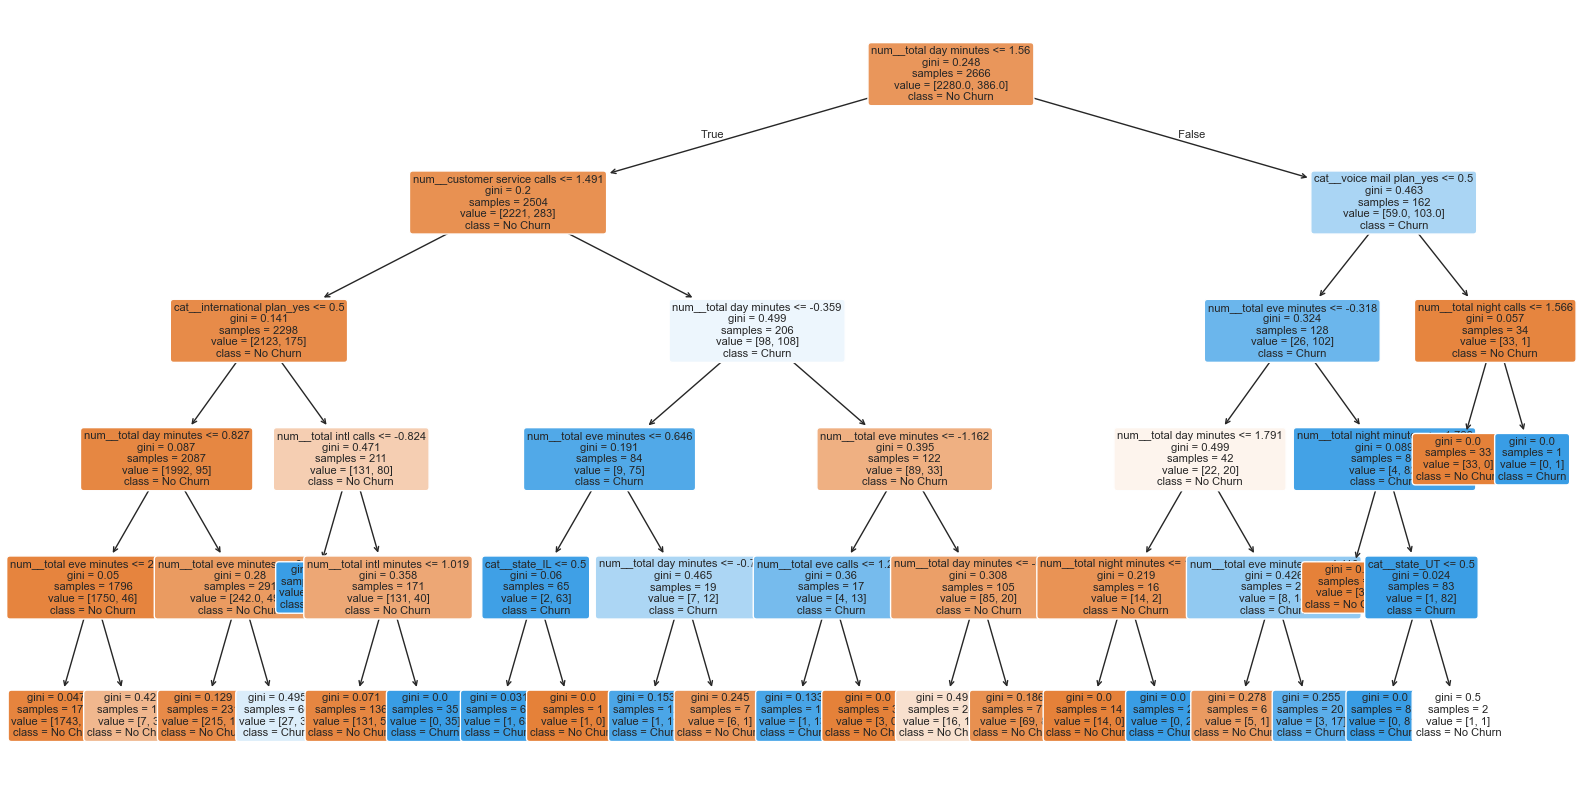

In [60]:
#fit a plain tree on the preprocessed training data
tree_clf = Pipeline([
    ('prep', preprocessor),
    ('clf', DecisionTreeClassifier(max_depth=5, random_state=42))
])
tree_clf.fit(X_train, y_train)

# Get the trained tree from the pipeline
fitted_tree = tree_clf.named_steps['clf']

plt.figure(figsize=(20, 10))
plot_tree(
    fitted_tree,
    feature_names=tree_clf.named_steps['prep'].get_feature_names_out(),
    class_names=['No Churn', 'Churn'],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()


The tree diagram shows how the model splits customers to predict churn.

- *Top split:* `customer service calls` is the first key factor; many calls signal a higher chance of churn.  
- *Subsequent splits:* Features like `international plan`, `total day minutes`, and evening usage further separate churners from non-churners.   
- *Color intensity:* Dark orange = strong “No Churn” prediction; dark blue = strong “Churn” prediction.

Reading from root to leaves reveals the main decision rules the model uses, making it easy to explain churn predictions to stakeholders.

### III. XGBoost
We trained an XGBoost classifier, a gradient boosting model known for high accuracy and strong handling of non-linear relationships. It builds many small decision trees in sequence, where each tree corrects the errors of the previous ones. This approach often outperforms single models like logistic regression or a single decision tree, especially on structured tabular data.

In [61]:
#compute class weight ratio for XGBoost (not as direct as other models)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# create pipeline with class imbalance handled
xgb_pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=scale_pos_weight  # handles imbalance
    ))
])

# hyperparameter grid
xgb_param = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.05, 0.1]
}

# grid search with recall scoring
xgb_cv = GridSearchCV(xgb_pipe, xgb_param, cv=5, scoring='recall', n_jobs=-1)

# evaluate on train/test sets
xgb_scores = evaluate(xgb_cv, X_train, X_test, y_train, y_test)
xgb_scores

{'accuracy': 0.8755622188905547,
 'recall': 0.7525773195876289,
 'precision': 0.553030303030303,
 'f1': 0.6375545851528385}

XGBoost delivered the best results: **87.5% accuracy**, **75% recall**, and an **F1 score around 0.64**.  
It identifies more of churners while keeping false positives low. This balance of high recall and precision makes it the most effective model for predicting churn in this dataset.

### IV. Retrain Best Model
We’re running the model on all the training data with the best parameters we found so it uses all the info.


In [62]:
best_model = xgb_cv.best_estimator_  # already fitted, but to be explicit
best_model.fit(X_train, y_train)     # full training fold

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['state',
                                                   'international plan',
                                                   'voice mail plan']),
                                                 ('num', StandardScaler(),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total eve minutes',
                                                   'total eve calls',
                                                   'total night minutes',
                                                   'total night calls',
                                                   'total intl minutes',
                                                   't...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

## V. Feature Importance
Let's check which features affect the model’s predictions the most.

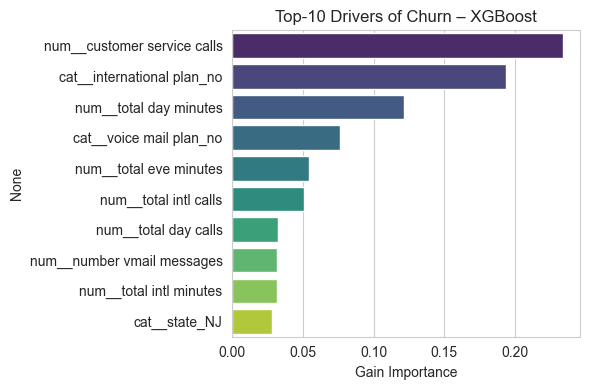

In [63]:
# get feature importances from the trained XGBoost model
importances = best_model.named_steps['clf'].feature_importances_

# get feature names after preprocessing (one-hot encoded + scaled)
feat_names = best_model.named_steps['prep'].get_feature_names_out()

#create a DataFrame/Series of top 10 features by importance
imp_df = (pd.Series(importances, index=feat_names)
            .sort_values(ascending=False)
            .head(10))

# Plot the top 10 most important features
plt.figure(figsize=(6, 4))
sns.barplot(x=imp_df.values, y=imp_df.index, palette='viridis')
plt.title('Top-10 Drivers of Churn – XGBoost')
plt.xlabel('Gain Importance')  #importance metric from XGBoost
plt.tight_layout()
plt.show()


### Top-10 Drivers of Churn – XGBoost (Gain Importance)

1. *No International Plan* – strongest churn driver; plan holders are much less likely to leave.  
2. *No Voice Mail Plan* – absence of this add-on also increases churn risk.  
3. *Customer Service Calls* – steep risk rise after 3–4 calls; early dissatisfaction signal.  
4. *Total Day Minutes* – heavy daytime users more likely to churn (burnout/overpricing frustration).  
5. *Total International Minutes* – frequent int’l usage without a plan flags at-risk customers.  
6. *Total International Calls* – same effect as above, reinforcing the upsell opportunity.  
7. *Total Evening Minutes* – secondary risk factor; high evening usage adds to churn likelihood.  
8. *State = NJ* – geographic effect; weaker than usage/plan features but still detectable.  
9. *Total Night Minutes* – minor driver; churners not strongly clustered here.  
10. *Number of Voicemail Messages* – smallest influence; aligns with VM plan effect.  

*Business takeaway*: churn is concentrated in customers with **no value-add plans**, **high usage (esp. day/eve/int’l)**, and **multiple service calls**. These segments should be prioritized for retention offers and proactive outreach.


### Partial Dependence: Customer Service Calls 
This shows how the number of service calls affects the chance of churn.

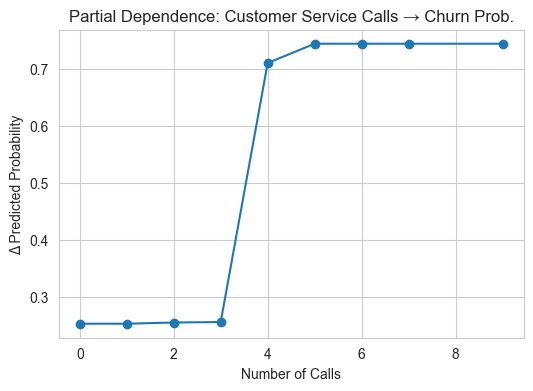

In [ ]:
pd_results = partial_dependence(
        best_model, X_train,
        features=['customer service calls'],
        kind='average')

plt.figure(figsize=(6, 4))
plt.plot(pd_results['grid_values'][0], pd_results['average'][0], marker='o')
plt.title('Partial Dependence: Customer Service Calls → Churn Prob.')
plt.xlabel('Number of Calls')
plt.ylabel('Predicted Probability')
plt.show()

Churn probability stays low (about 10%) for customers with **0–2 service calls**, then rises sharply after the **3rd call**, plateauing around **50% churn risk**.  
*Business action*: treat *4 or more calls* as a red flag; intervene proactively (priority support or retention offers) before dissatisfaction escalates.

# **Conclusion**

Our analysis, which included data visualization, statistical testing, and machine learning, identified the most significant factors contributing to customer attrition. The primary churn catalysts are:

* *The International Plan:* A statistically significant correlation exists between having an international plan and an elevated churn risk. This often stems from unexpected costs, or "bill shock," a common issue that a 2022 Harvard Business Review study found is a major driver of customer dissatisfaction. Companies like T-Mobile have successfully mitigated this with transparent, all-inclusive international plans.

* *Customer Service Interactions:* The probability of churn increases sharply after a customer's third service call, indicating a critical "tipping point of dissatisfaction." According to Microsoft's Global State of Customer Service Report, nearly 60% of consumers will switch brands after one or two poor experiences. Empowering front-line agents to resolve issues quickly, similar to Zappos's customer-centric model, is crucial for preventing this escalation.

* *High Usage Patterns:* Customers with very high day and international usage are more likely to churn. This suggests a perceived "value cliff," where the service cost is disproportionate to the value received. Telecom providers like Verizon and AT&T have addressed this with tiered data plans and better "unlimited" options to provide more value for heavy users, which can reduce churn.

* *Lack of Value-Add Services:* The absence of features like a voicemail plan is strongly correlated with a higher churn rate, demonstrating the "protective effect" of service bundling. A Deloitte study on customer loyalty found that bundled services can increase customer lifetime value by up to 30% and significantly reduce churn.

* *Geographic Concentration:* Churn rates are not uniform; they are concentrated in specific states, especially when combined with other risk factors. New Jersey is the most at-risk state. This concentration allows for targeted interventions, a strategy that companies like Comcast have used to implement localized promotions to counter competitor activity in specific regions.

---

# **Business Recommendations**

Based on these findings, we provide six strategic recommendations to address these core drivers:

1.  **Implement a Proactive Retention Program:** Use machine learning models as an early warning system to identify and engage with at-risk customers before they churn. Companies like Netflix and Spotify use similar AI models to personalize content and offers, which helps retain subscribers.

2.  **Redesign Plan Offerings:** Restructure international and high-usage plans to eliminate "bill shock" by introducing tiered pricing models that provide better value and reward heavy consumption.

3.  **Enhance Customer Service and Support:** Empower front-line agents and improve self-service options to resolve issues quickly and prevent dissatisfaction from escalating. Companies like Southwest Airlines have built strong brand reputations on the foundation of exceptional customer service.

4.  **Increase Value Through Service Bundling:** Strategically package core services with value-add features to increase perceived value and enhance customer loyalty. The Amazon Prime model, which bundles shipping, streaming, and other perks, is a prime example of this strategy.

5.  **Introduce a Tiered Loyalty Program:** Develop a modern loyalty program that offers both long-term benefits and personalized, immediate rewards to retain high-value customers. The tiered system used by the Starbucks rewards program is a successful example of driving repeat business.

6.  **Leverage Geographic Initiatives:** Tailor marketing and retention campaigns to high-churn areas and customer profiles. This targeted approach is more efficient and effective than a one-size-fits-all strategy.